In [1]:
import scipy.io
import numpy as np
from numpy.fft import fft, rfft, rfftfreq, fftfreq
import pandas as pd
from os import listdir, path
from os.path import isfile, join
import datetime
import dateutil.parser as parser
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, hanning, welch, get_window, periodogram
import cProfile
import time

# Prepare the Data

In [2]:
fs = 25000  # sampling frequency 25kHz
T = 10  # time of signal 10s
n = 999 # number of signals
N = fs * T  # number of samples
dt = 1 / fs

Single signal is in the following format:
```
signals = np.array([
            single_signal=[
                  datetime, data
                  ],
                  ...
          ])
```

## Generator extracting all data from MATLAB files
Sort the list of filenames lexicographically.
> Google Collabs changes the order for some reason (probably because of different default data storing order order on Google Drive).
> In PyCharm it works without any sorting, however this step does not take much time and does not impact the performance much.

### Change the MATLAB timestamp format to YYY-MM-dd HH:mm:ss
MATLAB provides a default timestamp format ```2020-JAN-01 00:00:00```.

My approach here is to convert it to the more useful datetime format ```YYYY:MM:dd HH:mm:ss```, in order to use the DateTimeIndex in *pandas.DataFrame* objects later.

> parser.parse(timestamp)

In [3]:
def extract_all_data_from_mat(mat_path, n_signals=999):

    # Use sorted list of filenames
    only_files = sorted([file for file in listdir(mat_path) if isfile(join(mat_path, file))])
    assert len(only_files) == n_signals, 'Number of files must be equal to 999!'
    
    signal_names = []
    timestamps = []
    data = []
    
    for file_name in only_files:
            try:

                mat_file = path.join(mat_path, file_name)
                mat = scipy.io.loadmat(mat_file)
                
                # 'signal_1'
                signal_name = f'{file_name[:6]}_{int(file_name[-8:-4])}'
                
                # timestamp
                extracted_timestamp = parser.parse(mat['timestamp_str'][0])

                # numpy array containing data
                extracted_data = mat['data'][0]

            except TypeError:
                print(f'{file_name} is corrupted.')
            else:
                signal_names.append(signal_name)
                timestamps.append(extracted_timestamp)
                data.append(extracted_data)
                
    return signal_names, timestamps, np.array(data, dtype=np.float64)

In [4]:
mat_files_path = r'C:\Users\szczy\Bachelor\MODE 7 - Miscellaneous\Data mat'

# Numpy array containing data extracted from MATLAB files
# all_data = np.vstack([data for data in extract_all_data_from_mat(mat_files_path)])
signal_names, timestamps, data = extract_all_data_from_mat(mat_files_path)

## Create DataFrame for the full dataset
1. DataFrame will be grouped by signal name.
2. Each DataFrame column name will correspond to:
    * timestamp
    * N-th sample

### DataFrame containing all data

In [5]:
mode7_df = pd.DataFrame(
    data=np.column_stack((timestamps, data)), # timestamp, n1, n2, .. nN
    index=signal_names, # signal1, signal2, .., signaln
    columns=np.hstack(('Date', [i for i in range(N)])), # Date, 0, 1, .., N-1
)

mode7_df.head()

,Date,0,1,2,3,4,5,6,7,8,...,249990,249991,249992,249993,249994,249995,249996,249997,249998,249999
signal_1,2020-10-16 10:51:26,0.0401394,-0.0139534,-0.374629,-0.430754,-1.2797,-1.6967,-1.29425,-0.727258,0.020795,...,-0.300496,-0.790838,-0.540505,0.372666,0.544504,0.150038,-0.00473425,0.527103,0.714635,-0.207416
signal_2,2020-10-17 10:51:26,-0.0191368,-0.114124,-0.823414,-1.11509,-0.905094,-0.189646,1.29452,2.00944,1.55269,...,-0.709162,-0.367087,-0.12923,-0.114574,-0.117939,-0.721022,-0.391528,-0.339336,-0.0611727,0.388111
signal_3,2020-10-18 10:51:26,0.246735,0.420629,0.23372,-0.252937,-0.73316,-0.0722741,-0.335648,-0.852295,-0.853636,...,1.00505,1.10012,1.21395,0.615521,-0.368691,0.290896,0.967391,0.101787,-0.485911,-0.355975
signal_4,2020-10-19 10:51:26,-0.992886,-0.987975,-0.690192,0.136254,0.694803,0.226265,-0.867183,-2.14953,-1.67654,...,0.48853,-0.0547785,-0.0301171,-0.234258,0.352841,0.0222006,-0.945641,-0.164169,-0.237284,0.0241828
signal_5,2020-10-20 10:51:26,-0.191269,-0.237793,-0.151192,-0.87523,-1.07959,-1.04572,-0.927799,0.25105,1.34632,...,-0.827944,-0.228974,-0.0854558,-0.920004,-0.782188,0.236261,0.7091,0.447058,0.125537,-0.0442359


## Export the CSV containing data for all signals

In [6]:
# mode7_dfT.to_csv('D:\Praca Inżynierska\csv_files\mode7_transposed_full.csv')

### Conclusion:
> It is better to actually gather the data directly from .mat files, instead of creating the CSV neither in MATLAB nor using Python scripts.

The reason for that is the total amount of data. We have 999 datetime objects as index, however in case of t=10s and fs=25kHz, the total number of samples is 250,000. The CSV weights ~4.9Gb and I cannot open it in any spreadsheet.

There are 2 solutions for that issue:
* Work temporarily on the DataFrame containing all data from extracted .mat files
* Use averaging


# Calculate RMS for each signal

In [186]:
def root_mean_square(data):
    return np.sqrt(np.mean(np.square(data), axis=1))

In [187]:
mode7_rms = root_mean_square(data)

## Create a DataFrame containing RMS for each signal.

In [209]:
mode7_rms_df = pd.DataFrame(
    data=np.column_stack((timestamps, mode7_rms)), 
    index=signal_names, 
    columns=['Date', 'RMS']
)
mode7_rms_df.RMS = mode7_rms_df.RMS.astype(np.float64)

mode7_rms_df.head()

,Date,RMS
signal_1,2020-10-16 10:51:26,0.398396
signal_2,2020-10-17 10:51:26,0.396055
signal_3,2020-10-18 10:51:26,0.398734
signal_4,2020-10-19 10:51:26,0.425583
signal_5,2020-10-20 10:51:26,0.398431


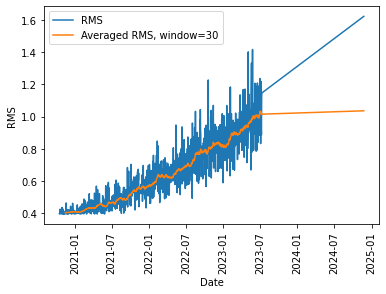

In [222]:
plt.plot(
    mode7_rms_df.Date,
    mode7_rms_df.RMS,
    label='RMS')
plt.plot(
    mode7_rms_df.Date,
    mode7_rms_df.RMS.rolling(window=30).mean(),
    label='Averaged RMS, window=30'
)
plt.xticks(rotation='vertical')
plt.xlabel('Date')
plt.ylabel('RMS')
plt.legend()
plt.show()

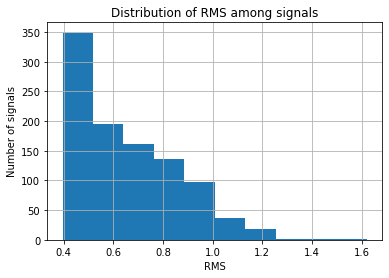

In [223]:
mode7_rms_df['RMS'].hist()
plt.title('Distribution of RMS among signals')
plt.xlabel('RMS'), plt.ylabel('Number of signals')
plt.show()

## Export RMS .csv

In [11]:
# mode7_rms_df.to_csv('D:\Praca Inżynierska\csv_files\MODE7_RMS.csv')

# Frequency Analysis
Digital signals can be analised in time and frequency domain. Algorithms based on the time domain operate directly on samples from digital signal. **Frequency analysis** of the signal is about transforming the signal from time to frequency domain. **Spectrum** of the signal is a visual representation of the frequency, usually the **Frequency analysis** is alternatively called **Spectrum analysis**.

*Jean-Baptiste Joseph Fourier* discovered, that any periodic signal can be represented as **Fourier Series**, that is the sum of trigonometric signals (cosines and sines) characterized by different amplitudes and frequencies.

The operation of transformation the signal from time to frequency domain is called the **Fourier Transform**. In case of discrete signals (digital), we refer to the **Discrete Fourier Transform**.

The practical use of **Fourier Transform** applies to the **Fast Fourier Transform* algorithm.

> *numpy* library contains the ```numpy.fft``` module, in which the ```fft()``` method is implemented

## Magnitude Spectrum
Based on n samples from the digital signal, we can calculate n values for the complex spectrum. Since the spectrum of the signal is complex, we usually analyse the module of the spectrum. The most commonly analysed is the **Magnitude Spectrum**.

> **Magnitude Spectrum** is obtained with the use of ```numpy.abs()``` method, taking the FFT of the time-domain signal as an argument.

## Spectral averaging (Uśrednienie widma) for Magnitude Spectrum
* k = the level of averaging

For ```t=10s``` signal with sampling frequency ```fs=25kHz``` we obtain total number of samples ```N=250,000``` *(fs * t)*.

We segment the signal into ```k=100``` equal ```dt=0.1s``` (t/k) data chunks, containing ```chunk_n_samples=2,500``` *(N / k)* samples.

On each part of the signal, we calculate the **Magnitude Spectrum** and then take an average from it.

We will receive k *spectrum lines* occurring every ```df=10Hz``` *(1 / (t/k))*.

In [12]:
# SINE WAVE SIGNAL PARAMETERS
T = 1   # total signal time
fs = 100 # sampling frequency
N = T * fs  # total number of samples, also defined as len(signal)
dt = 1 / fs
t = np.arange(0, T, dt)
x = np.arange(N)
f = 4 # signal frequency

Based on N signal samples we receive N spectral values, covering the range between 0 and fs, where *fs / 2* is the
**Nyquist frequency**. The difference between these 2 points is *fs / N* (**spectral resolution**).

Based on N signal samples we receive **(N / 2) + 1** values of complex spectrum if N is even, and **(N - 1) / 2** if N
is odd. First value of FFT is a **constant spectral component**, calculated as the sum of signal values. If N is even,
last value of the result represents the spectral component for the Nyquist frequency.

1) Get the time-domain signal

Option 1: Signal based on time domain

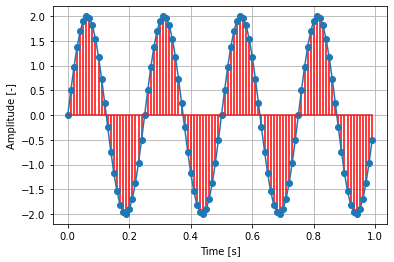

In [13]:
y = 2 * np.sin(2 * np.pi * f * t)
plt.plot(t, y)
plt.stem(t, y, 'r')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [-]')
plt.grid(True)
plt.show()

Option 2: Signal based on number of samples

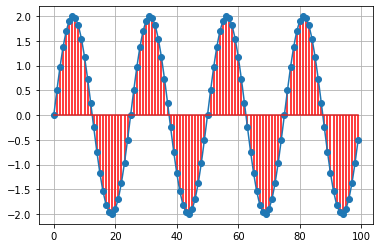

In [14]:
y = 2 * np.sin(2 * np.pi * f * x / fs)
plt.plot(x, y)
plt.stem(x, y, 'r')
plt.grid(True)
plt.show()

### Calculate Spectral Amplitudes for exemplary sine wave
#### 1) Generate signal

In [15]:
y = 2 * np.sin(2 * np.pi * f * t)

#### 2) Fast Fourier Transform (complex output)

In [16]:
y_spectrum = fft(y)

#### 3) Spectral Amplitudes - absolute value of complex numbers

In [17]:
y_magnitude_spectrum = np.abs(y_spectrum)

#### 4) One-sided magnitude spectrum, including DC and fs/2 spectral components

In [18]:
y_real_magnitude_spectrum = np.abs(rfft(y))

#### 5) Scaling with respect to the number of samples
Scaling the spectrum is based on division by half of the FFT's length (N/2), so the spectrum values can be
representative of the energy of each spectral component, since the signal's energy is spread equally into two parts of
spectrum, and we are analysing only one (real) part of them.

In [19]:
y_real_magnitude_spectrum /= (N / 2)

In [20]:
df = 1 / T  # spectral resolution, also defined as fs / N
freq = rfftfreq(N, dt)  # or np.arange(0, (fs / 2) + 1, df)
freq

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.])

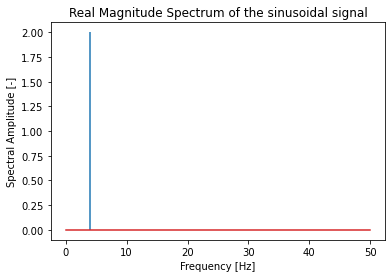

In [21]:
plt.stem(freq, y_real_magnitude_spectrum, markerfmt='none')
plt.xlabel('Frequency [Hz]'), plt.ylabel('Spectral Amplitude [-]')
plt.title('Real Magnitude Spectrum of the sinusoidal signal')
plt.show()

### Spectrum Averaging for the Dataset

In [22]:
# SIGNAL PARAMETERS
k = 100 # level of averaging

fs = 25e3 # sampling frequency
T = 10 # time
dt = 1 / fs # time step
t = np.arange(0, T, dt) # time vector

signal_0001 = data[0] # first signal
N = len(signal_0001) # total number of samples per signal

In [23]:
total_power_0001 = np.sum(np.square(signal_0001)) / N
print('Total power of signal_0001:', total_power_0001)

Total power of signal_0001: 0.15871961797008455


#### Spectogram

In [24]:
M = N / k # total number of samples divided into k-equal chunks
window = np.hamming(M)   # Hanning window
overlap = 0.5   # 50% overlap
n_overlap = int(round(M * overlap)) # overlap in samples
_f, _t, _Sxx = spectrogram(signal_0001,
                           fs=fs,
                           window=window,
                           nperseg=M, # samples per segment
                           noverlap=n_overlap, # overlapping samples
                           scaling='spectrum',
                           mode='magnitude')

# Compute the average spectrum
_avg_spectrum = np.mean(_Sxx, axis=1)
print('Average Spectrum computed from Spectrogram:\n', _avg_spectrum)

Average Spectrum computed from Spectrogram:
 [5.14687674e-03 1.02372299e-02 1.13565142e-02 ... 8.09250885e-05
 7.36077358e-05 6.31186593e-05]


#### Welch’s power spectral density estimate
Welch’s method computes an estimate of the power spectral density by dividing the data into overlapping segments,
computing a modified periodogram for each segment and averaging the periodograms.
##### Power Spectral Density

In [25]:
M = N / k # length of each segment
window = np.hamming(M)
overlap = .5
n_overlap = M * overlap

In [26]:
f_den, Pxx_den = welch(signal_0001,
                         fs=fs,
                         window=window,
                         nperseg=M,
                         noverlap=n_overlap,
                         scaling='density',
                         average='mean')

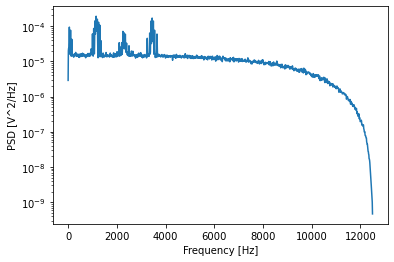

In [27]:
plt.semilogy(f_den, Pxx_den, label='signal_0001')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V^2/Hz]')
plt.show()

##### Power Spectrum

In [28]:
f_spec, Pxx_spec = welch(signal_0001,
                         fs=fs,
                         window=window,
                         nperseg=M,
                         noverlap=n_overlap,
                         scaling='spectrum',
                         average='mean')

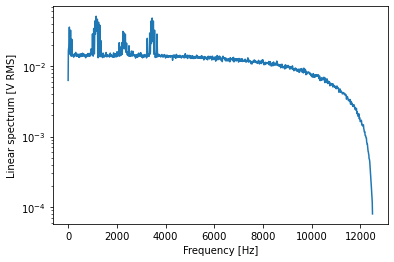

In [29]:
plt.semilogy(f_spec, np.sqrt(Pxx_spec), label='signal_0001')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.show()

#### Analysis of different solutions to Averaged Spectrum Generator for input time-domain signal.

In [30]:
# MANUAL APPROACH
spectrum_0001_m = fft(signal_0001)    # 2. FFT (complex output)
spectrum_0001_m = np.abs(spectrum_0001_m)   # 3. Spectral amplitudes - absolute value of complex numbers
spectrum_0001_m = spectrum_0001_m[:int(N / 2) + 1] # 4. One-sided spectrum, including DC and fs/2 components
spectrum_0001_m = spectrum_0001_m / (N / 2) # 5. Scaling with respect to the number of samples

f_0001_m = np.linspace(start=0, stop=int(fs / 2), num=int(N / 2) + 1, endpoint=True)

#######################################################################################################################
# FUNCTIONAL APPROACH
spectrum_0001 = rfft(signal_0001)   # 1. FFT on real input values
spectrum_0001 = np.abs(spectrum_0001)   # 2. One-sided Spectral amplitudes, including DC and fs/2 components
spectrum_0001 = spectrum_0001 / (N / 2) # 3. Scaling with respect to the number of samples

df = fs / N
f_0001 = rfftfreq(N, dt)

In [31]:
assert all(np.round(spectrum_0001_m, 8) == np.round(spectrum_0001, 8)) and all(f_0001_m == f_0001), print('Manual approach results in different values than functional.')

Manual FFT approach gives the same results as the Functional approach.

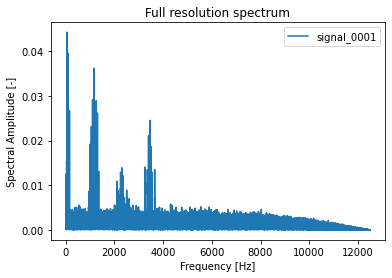

In [32]:
plt.plot(f_0001, spectrum_0001, label='signal_0001')
plt.xlabel('Frequency [Hz]'), plt.ylabel('Spectral Amplitude [-]')
plt.title('Full resolution spectrum')
plt.legend()
plt.show()


In [33]:
signal_0999 = data[-1]

##### Methods used for Spectrum Averaging

In [34]:
# SPECTRUM AVERAGING: METHOD 1
def spectrum_averaging_method_1(_signal, _k):
    # 1. DIVIDE THE SIGNAL INTO K-EQUAL FRAGMENTS
    for chunk in np.split(_signal, _k):
        _N = len(chunk)
        # 2. CALCULATE THE SPECTRUM FOR EACH CHUNK
        spectrum = np.abs(rfft(chunk)) / (_N / 2)
        # 3. TAKE THE MEAN VALUE OF THE SPECTRUM
        yield np.mean(spectrum)

# SPECTRUM AVERAGING: METHOD 2
def spectrum_averaging_method_2(_signal, _k):
    _N = len(_signal)
    # 1. CALCULATE THE SPECTRUM FOR SIGNAL
    spectrum = np.abs(rfft(_signal)) / (_N / 2)
    # 2. DIVIDE THE SPECTRUM INTO K FRAGMENTS
    for chunk in np.array_split(spectrum, _k):
        # 3. TAKE THE MEAN VALUE OF THE SPECTRUM FRAGMENT
        yield np.mean(chunk)

In [35]:
start_1 = time.time()
spectrum_0999_1 = np.array([avg_spectrum_1 for avg_spectrum_1 in spectrum_averaging_method_1(signal_0999, k)])
end_1 = time.time()
exec_time_1 = end_1 - start_1
print(f'Execution time of Method 1: {exec_time_1}s')


start_2 = time.time()
spectrum_0999_2 = np.array([avg_spectrum_2 for avg_spectrum_2 in spectrum_averaging_method_2(signal_0999, k)])
end_2 = time.time()
exec_time_2 = end_2 - start_2
print(f'Execution time of Method 2: {exec_time_2}s')


freq_0999 = np.arange(start=0, stop=k * T, step=1 / (T / k))

Execution time of Method 1: 0.011484384536743164s
Execution time of Method 2: 0.01714777946472168s


In [36]:
time_delta = abs(exec_time_2 - exec_time_1)
if exec_time_2 < exec_time_1:
    print(f'Method 2 is faster by {np.round(time_delta * 100 / exec_time_1, 2)} %')
else:
    print(f'Method 1 is faster by {np.round(time_delta * 100 / exec_time_2, 2)} %')

Method 1 is faster by 33.03 %


###### Time of Method 1

In [37]:
cProfile.run('np.array([avg_spectrum_1 for avg_spectrum_1 in spectrum_averaging_method_1(signal_0999, k)])')

         3426 function calls (3324 primitive calls) in 0.033 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.001    0.001 <__array_function__ internals>:2(array_split)
      100    0.000    0.000    0.008    0.000 <__array_function__ internals>:2(mean)
      100    0.000    0.000    0.014    0.000 <__array_function__ internals>:2(rfft)
        1    0.000    0.000    0.001    0.001 <__array_function__ internals>:2(split)
      101    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(swapaxes)
      101    0.009    0.000    0.033    0.000 <ipython-input-34-edf67472957a>:2(spectrum_averaging_method_1)
        1    0.000    0.000    0.033    0.033 <string>:1(<listcomp>)
        1    0.000    0.000    0.033    0.033 <string>:1(<module>)
      100    0.000    0.000    0.000    0.000 _asarray.py:14(asarray)
      100    0.000    0.000    0.000    0.000 _asarray.py:86(asanyarray)
   

###### Time of Method 2

In [38]:
cProfile.run('np.array([avg_spectrum_2 for avg_spectrum_2 in spectrum_averaging_method_2(signal_0999, k)])')

         2431 function calls (2330 primitive calls) in 0.019 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(array_split)
      100    0.000    0.000    0.003    0.000 <__array_function__ internals>:2(mean)
        1    0.000    0.000    0.012    0.012 <__array_function__ internals>:2(rfft)
      101    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(swapaxes)
      101    0.003    0.000    0.018    0.000 <ipython-input-34-edf67472957a>:12(spectrum_averaging_method_2)
        1    0.000    0.000    0.019    0.019 <string>:1(<listcomp>)
        1    0.000    0.000    0.019    0.019 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 _asarray.py:14(asarray)
      100    0.000    0.000    0.000    0.000 _asarray.py:86(asanyarray)
      100    0.001    0.000    0.002    0.000 _methods.py:143(_mean)
      100    0.000 

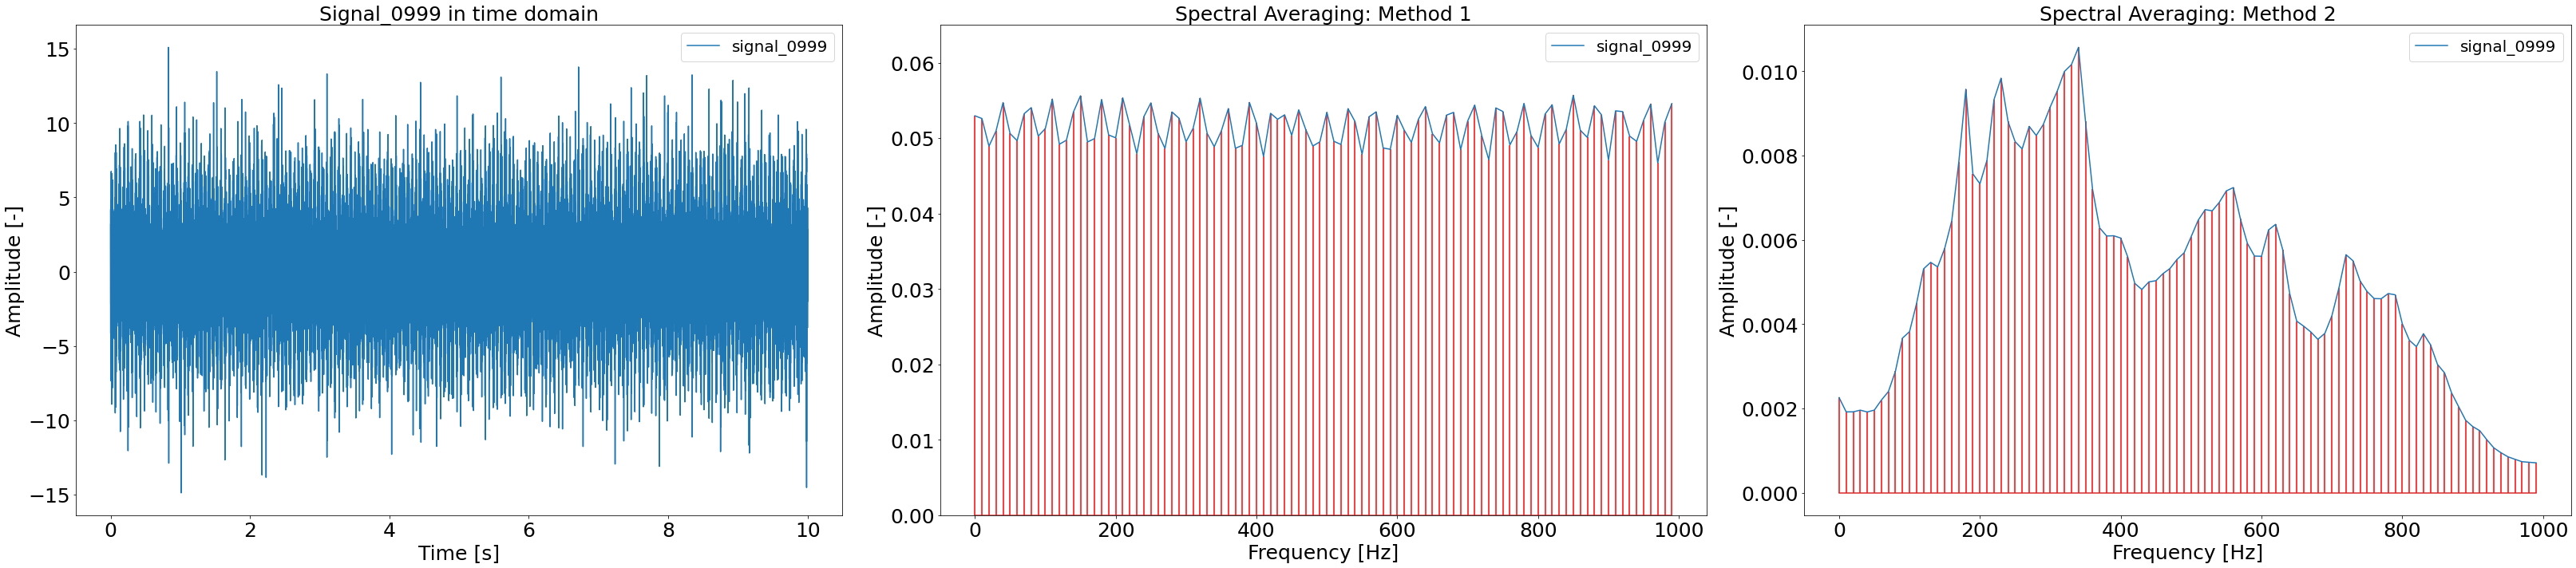

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(45, 10))

ax[0].plot(t, signal_0999, label='signal_0999')
ax[0].set_xlabel('Time [s]', fontsize=25)
ax[0].set_ylabel('Amplitude [-]', fontsize=25)
ax[0].set_title('Signal_0999 in time domain', size=25)
ax[0].tick_params(axis='both', which='major', labelsize=25)
ax[0].tick_params(axis='both', which='minor', labelsize=18)
ax[0].legend(fontsize=20)

ax[1].plot(freq_0999, spectrum_0999_1, label='signal_0999')
ax[1].stem(freq_0999, spectrum_0999_1, 'r', markerfmt='none')
ax[1].set_xlabel('Frequency [Hz]', fontsize=25), ax[1].set_ylabel('Amplitude [-]', fontsize=25)
ax[1].set_title('Spectral Averaging: Method 1', size=25)
ax[1].tick_params(axis='both', which='major', labelsize=25)
ax[1].tick_params(axis='both', which='minor', labelsize=18)
ax[1].set_ylim((0, 0.065))
ax[1].legend(fontsize=20, loc='upper right')

ax[2].plot(freq_0999, spectrum_0999_2, label='signal_0999')
ax[2].stem(freq_0999, spectrum_0999_2, 'r', markerfmt='none')
ax[2].set_xlabel('Frequency [Hz]', fontsize=25), ax[2].set_ylabel('Amplitude [-]', fontsize=25)
ax[2].set_title('Spectral Averaging: Method 2', size=25)
ax[2].tick_params(axis='both', which='major', labelsize=25)
ax[2].tick_params(axis='both', which='minor', labelsize=15)
ax[2].legend(fontsize=20)

plt.tight_layout()
plt.savefig('signal_0999.jpg', bbox_inches='tight')
plt.show()

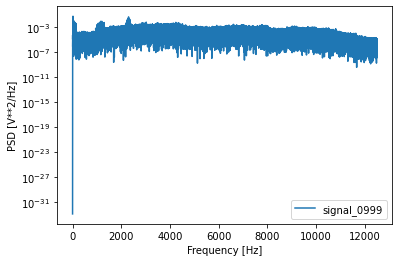

In [40]:
fr999, Pxx_den_0999 = periodogram(signal_0999, fs, scaling='density')
plt.semilogy(fr999, Pxx_den_0999, label='signal_0999')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()
plt.show()

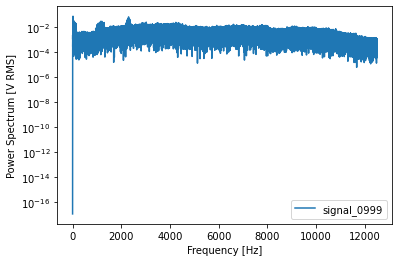

In [41]:
fr999, Pxx_spec_0999 = periodogram(signal_0999, fs, scaling='spectrum')
plt.semilogy(fr999, np.sqrt(Pxx_spec_0999), label='signal_0999')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectrum [V RMS]')
plt.legend()
plt.show()

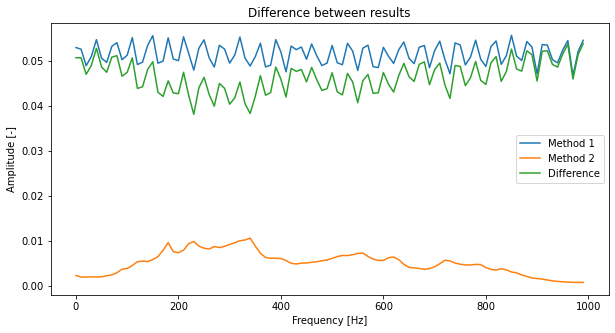

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(freq_0999, spectrum_0999_1, label='Method 1')
plt.plot(freq_0999, spectrum_0999_2, label='Method 2')
plt.plot(freq_0999, spectrum_0999_1 - spectrum_0999_2, label='Difference')
plt.xlabel('Frequency [Hz]'), plt.ylabel('Amplitude [-]')
plt.title('Difference between results')
plt.legend()
plt.show()

In [43]:
N_0999 = len(signal_0999)
overlap_0999 = 0.5
k_exp = np.round(np.log10(k)).astype(int)
nperseg_0999 = int(k / overlap_0999) - 2 ** (k_exp - 1)    # in order to obtain k-average values
window_0999 = np.hamming(nperseg_0999)
noverlap_0999 = int(overlap_0999 * nperseg_0999)

#### Welch's estimate
##### Power Spectrum Density


In [44]:
f_den_0999, Pxx_den_0999 = welch(signal_0999,
                                 fs=fs,
                                 nperseg=nperseg_0999,
                                 noverlap=noverlap_0999,
                                 scaling='density',
                                 average='mean')

##### Power Spectrum

In [45]:
f_spec_0999, Pxx_spec_0999 = welch(signal_0999,
                                 fs=fs,
                                 nperseg=nperseg_0999,
                                 noverlap=noverlap_0999,
                                 scaling='spectrum',
                                 average='mean')

In [46]:
assert Pxx_den_0999.shape[0] == Pxx_spec_0999.shape[0] == 100, f'The Averaged Spectrum does not contain {k} values!'

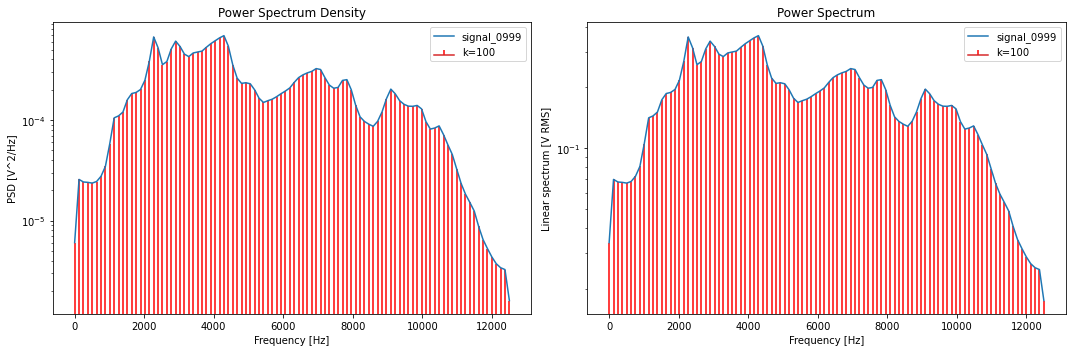

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].semilogy(f_den_0999, Pxx_den_0999, label='signal_0999')
ax[0].stem(f_den_0999, Pxx_den_0999, 'r', label=f'k={k}', markerfmt='none')
ax[0].set_title('Power Spectrum Density')
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_ylabel('PSD [V^2/Hz]')
ax[0].legend(loc='upper right')

ax[1].semilogy(f_spec_0999, np.sqrt(Pxx_spec_0999), label='signal_0999')
ax[1].stem(f_spec_0999, np.sqrt(Pxx_spec_0999), 'r', label=f'k={k}', markerfmt='none')
ax[1].set_title('Power Spectrum')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Linear spectrum [V RMS]')
ax[1].legend(loc='upper right')

plt.tight_layout()
plt.savefig('welch.jpg', bbox_inches='tight')
plt.show()

##### Spectrum Averaging using rolling mean approach.

In [48]:
def spectrum_moving_average(spectrum, window_size=2048, overlap=0.5):
    N = len(spectrum)
    noverlap = int(overlap * window_size)
    return [np.mean(spectrum[i:i + window_size]) for i in range(0, (N - window_size) + 1, noverlap)]

In [49]:
spectrum_0999 = np.abs(rfft(signal_0999)) / (N / 2)
f_0999 = rfftfreq(N, dt)

In [50]:
averaged_spectrum_0999 = spectrum_moving_average(spectrum=spectrum_0999, window_size=4096, overlap=0.5)
k_avg = len(averaged_spectrum_0999)
averaged_f_0999 = np.arange(0, 1 / (T / k_avg) * k_avg, 1 / (T / k_avg))
print(averaged_f_0999.shape)

(60,)


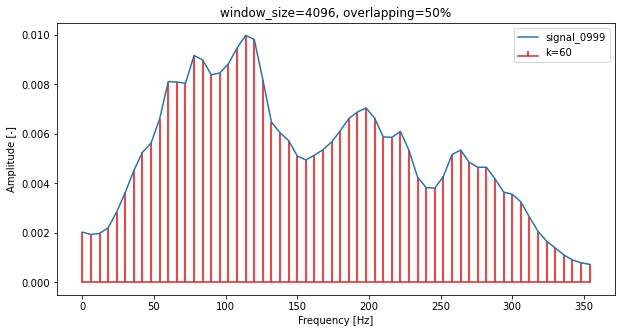

In [51]:
plt.figure(figsize=(10, 5))
plt.plot(averaged_f_0999, averaged_spectrum_0999, label='signal_0999')
plt.stem(averaged_f_0999, averaged_spectrum_0999, 'r', markerfmt='none', label=f'k={k_avg}')
plt.title('window_size=4096, overlapping=50%')
plt.xlabel('Frequency [Hz]'), plt.ylabel('Amplitude [-]')
plt.legend()
plt.show()

#### Conclusion:
Method 1 is a proper method for Spectrum Averaging. Moreover it is faster by ~30%.

In [52]:
def spectrum_averaging(signal, k=100):
    # 1. DIVIDE THE SIGNAL INTO K-EQUAL FRAGMENTS
    for chunk in np.split(signal, k):
            N = len(chunk)
            # 2. CALCULATE THE SPECTRUM FOR EACH CHUNK
            spectrum = np.abs(rfft(chunk)) / (N / 2)
            # 3. TAKE THE MEAN VALUE OF THE SPECTRUM
            yield np.mean(spectrum)

### Calculate the Averaged Spectrum for each signal 
For different value of *k*:

* k = 100
* k = 1,000
* k = (N / 2) + 1 (full spectrum)

And create DataFrame for each separate case.


    k = 100

In [53]:
mode7_averaged_spectrum_1e2 = np.vstack([[averaged_spectrum for averaged_spectrum in spectrum_averaging(signal, k=1e2)] for signal in data])
freq_1e2 = np.arange(0, 1e4 / T, 1 / (T / 1e2), dtype=np.int16)

mode7_averaged_spectrum_1e2_df = pd.DataFrame(
    data=np.column_stack((timestamps, mode7_averaged_spectrum_1e2)),
    index=signal_names,
    columns=['Date'] + [f'{int(i)} Hz' for i in freq_1e2]
)

mode7_averaged_spectrum_1e2_df.head()

,Date,0 Hz,10 Hz,20 Hz,30 Hz,40 Hz,50 Hz,60 Hz,70 Hz,80 Hz,...,900 Hz,910 Hz,920 Hz,930 Hz,940 Hz,950 Hz,960 Hz,970 Hz,980 Hz,990 Hz
signal_1,2020-10-16 10:51:26,0.0126222,0.0127481,0.0124391,0.0125191,0.0127339,0.0126472,0.0125721,0.012652,0.0125231,...,0.0126287,0.0124096,0.012868,0.012734,0.0129454,0.0124144,0.0126711,0.0128979,0.0123412,0.0125945
signal_2,2020-10-17 10:51:26,0.0125514,0.0127393,0.0125896,0.0124941,0.0123979,0.0126937,0.0128765,0.0125865,0.0128418,...,0.0124885,0.012539,0.012933,0.0126935,0.0127068,0.0124429,0.0127571,0.0124407,0.0125711,0.0127693
signal_3,2020-10-18 10:51:26,0.0126443,0.012792,0.0129672,0.0125232,0.0128189,0.0129332,0.0130013,0.012962,0.0124819,...,0.0125808,0.0124844,0.0127677,0.0128338,0.0129639,0.0126769,0.0126298,0.0122893,0.0128786,0.0128294
signal_4,2020-10-19 10:51:26,0.0140007,0.0136314,0.0138333,0.0135346,0.0135259,0.0136379,0.0140565,0.0137963,0.0139463,...,0.0135741,0.0138141,0.0136558,0.0138901,0.0135767,0.0134346,0.0136385,0.0138685,0.0136126,0.0135574
signal_5,2020-10-20 10:51:26,0.0128962,0.0128458,0.0126387,0.012416,0.0126011,0.0125848,0.0125915,0.0127322,0.012645,...,0.0127483,0.0126888,0.0126544,0.0129866,0.0128776,0.0125913,0.0125326,0.0125481,0.0122849,0.0127002


    k = 1,000

In [54]:
mode7_averaged_spectrum_1e3 = np.vstack([[averaged_spectrum for averaged_spectrum in spectrum_averaging(signal, k=1e3)] for signal in data])
freq_1e3 = np.arange(0, 1e6 / T, 1 / (T / 1e3), dtype=np.int32)

mode7_averaged_spectrum_1e3_df = pd.DataFrame(
    data=np.column_stack((timestamps, mode7_averaged_spectrum_1e3)),
    index=signal_names,
    columns=['Date'] + [f'{i} Hz' for i in freq_1e3]
)

mode7_averaged_spectrum_1e3_df.head()

,Date,0 Hz,100 Hz,200 Hz,300 Hz,400 Hz,500 Hz,600 Hz,700 Hz,800 Hz,...,99000 Hz,99100 Hz,99200 Hz,99300 Hz,99400 Hz,99500 Hz,99600 Hz,99700 Hz,99800 Hz,99900 Hz
signal_1,2020-10-16 10:51:26,0.0441727,0.0361355,0.0396044,0.0411147,0.0425636,0.0442132,0.0425403,0.0392685,0.0382083,...,0.0423977,0.0389074,0.0411627,0.0406033,0.0404418,0.0432543,0.0422253,0.0382376,0.0407579,0.0409473
signal_2,2020-10-17 10:51:26,0.0456173,0.037765,0.0380183,0.0367942,0.0396451,0.0421172,0.0423997,0.0383965,0.0399545,...,0.0438571,0.037921,0.0380937,0.0392596,0.0383983,0.0421214,0.0458013,0.038623,0.0382236,0.0431318
signal_3,2020-10-18 10:51:26,0.0459873,0.0383501,0.0401842,0.0386987,0.0375798,0.0450897,0.0412077,0.0407124,0.0415277,...,0.0424513,0.0387621,0.0379311,0.0425658,0.0408029,0.0443634,0.0449754,0.0353643,0.0403033,0.043065
signal_4,2020-10-19 10:51:26,0.0495733,0.0414597,0.0421853,0.0465691,0.0459611,0.0499721,0.0426837,0.0419189,0.0435907,...,0.0481914,0.0417496,0.0418553,0.0447003,0.0446226,0.0482705,0.0434199,0.040634,0.0400183,0.0434889
signal_5,2020-10-20 10:51:26,0.0455242,0.0393802,0.037768,0.0397078,0.0392529,0.0418728,0.0432778,0.0415083,0.0408174,...,0.0461982,0.0417026,0.0375544,0.0407842,0.0370783,0.0442376,0.0476458,0.0413494,0.0402684,0.0371765


    Spectrum of the whole signal, k = (N / 2) + 1

In [74]:
mode7_spectrum = np.vstack([np.abs(rfft(signal)) / (N / 2) for signal in data])
freq = np.round(rfftfreq(N, dt), decimals=1)

mode7spectrum_df = pd.DataFrame(
    data=np.column_stack((timestamps, mode7_spectrum)),
    index=signal_names,
    columns=['Data'] + [f'{i} Hz' for i in freq]
)

mode7spectrum_df.head()

,Data,0.0 Hz,0.1 Hz,0.2 Hz,0.3 Hz,0.4 Hz,0.5 Hz,0.6 Hz,0.7 Hz,0.8 Hz,...,12499.1 Hz,12499.2 Hz,12499.3 Hz,12499.4 Hz,12499.5 Hz,12499.6 Hz,12499.7 Hz,12499.8 Hz,12499.9 Hz,12500.0 Hz
signal_1,2020-10-16 10:51:26,0.000126407,0.000637862,0.00120611,0.0020032,0.00181584,0.0014517,0.00253326,0.00290333,0.000851475,...,1.40485e-05,2.29948e-05,1.12438e-05,7.59911e-06,3.17097e-05,7.08946e-06,4.46467e-06,8.98279e-06,1.16312e-05,9.64398e-06
signal_2,2020-10-17 10:51:26,0.0013183,0.00144861,0.000811993,0.000361053,0.00118522,0.00232747,0.00302261,0.000898974,0.000318986,...,7.38189e-06,1.01042e-05,4.2076e-06,1.5681e-05,1.23456e-05,8.36073e-06,1.13348e-06,2.4522e-06,1.06771e-05,1.48845e-06
signal_3,2020-10-18 10:51:26,0.000498003,0.000294003,0.00187002,0.00163823,0.00195169,0.00230835,0.00222132,0.000866506,0.00059357,...,6.09609e-06,1.7916e-05,2.52372e-05,2.25838e-05,1.37053e-05,3.44122e-05,1.83883e-05,1.85629e-05,3.31923e-05,1.51715e-05
signal_4,2020-10-19 10:51:26,0.00413189,0.00250577,0.00218633,0.00235548,0.00174877,0.00129761,0.00155503,0.00244414,0.00177648,...,3.4361e-05,6.58138e-05,5.05575e-05,0.000194684,9.01488e-05,0.000171813,8.49649e-05,0.000109395,0.000146984,1.87178e-05
signal_5,2020-10-20 10:51:26,0.00186094,0.00125063,0.000648304,0.00140687,0.00202915,0.00208441,0.00197544,0.000906026,0.00194576,...,4.36768e-06,2.22249e-05,1.05049e-05,1.08921e-05,9.62599e-06,6.84684e-06,2.08714e-05,4.58711e-06,1.32545e-05,2.15369e-06


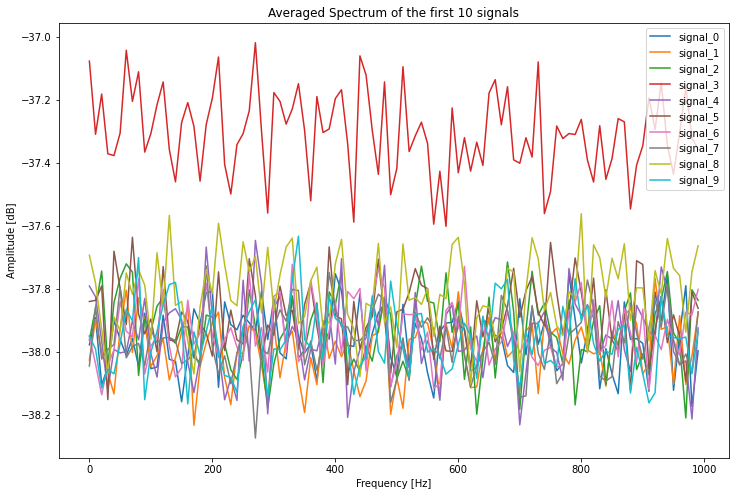

In [91]:
plt.figure(figsize=(12, 8))
for i in range(10):
    plt.plot(freq_1e2, 20 * np.log10(mode7_averaged_spectrum_1e2[i]), label=f'signal_{i}')
    plt.legend()

plt.title('Averaged Spectrum of the first 10 signals')
plt.xlabel('Frequency [Hz]'), plt.ylabel('Amplitude [dB]')
plt.show()

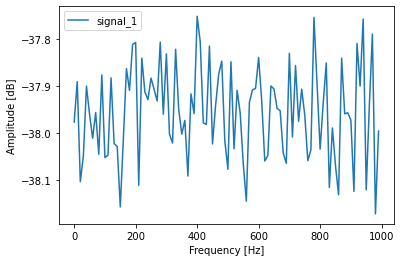

In [95]:
plt.plot(freq_1e2, 20 * np.log10(mode7_averaged_spectrum_1e2[0]), label='signal_1')
plt.xlabel('Frequency [Hz]'), plt.ylabel('Amplitude [dB]')
plt.legend()
plt.show()

## Clustering-Based Anomaly Detection
K-means is a widely used clustering algorithm for both classification and regression problems. It creates ‘k’ similar clusters of data points and can be used as either supervised or unsupervised learning technique. Data instances that lay outside of the formed clusters may be potentially treated as anomalies in time series. 
In order to find the optimal number of clusters for the K-Means clustering, the elbow method is used.

In [245]:
from sklearn.cluster import KMeans

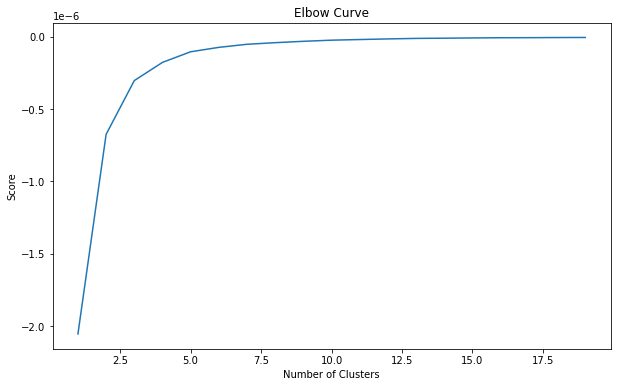

In [341]:
X = mode7_averaged_spectrum_1e2[0].reshape(-1, 1)

n_clusters = range(1, 20)
k_means = [KMeans(n_clusters=n).fit(X) for n in n_clusters]
scores = [k_means[i].score(X) for i in range(len(k_means))]

plt.figure(figsize=(10,6))
plt.plot(n_clusters, scores)
plt.xlabel('Number of Clusters'), plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Based on the elbow curve, we see that the graph starts to flatten after 3 clusters, thus applying higher number of clusters will not explain the variance.

In [348]:
k_means_model = KMeans(n_clusters=3)
k_means_model.fit(X)

KMeans(n_clusters=3)

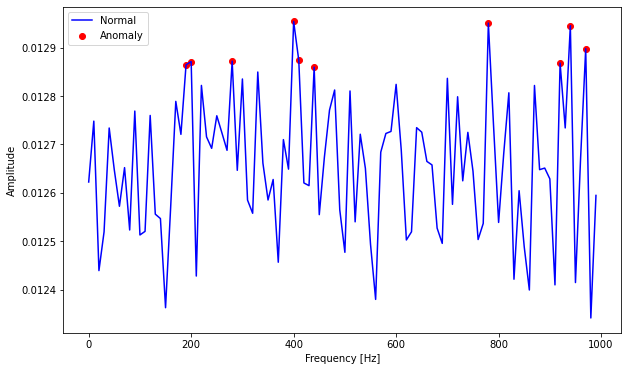

In [349]:
def get_distance_from_point(data, model):
    distance = pd.Series(dtype=np.float64)
    for i in range(len(data)):
        Xa = np.array(data[i])
        Xb = model.cluster_centers_[model.labels_[i] - 1]
        distance.at[i] = np.linalg.norm(Xa - Xb)
    return distance

outliers_fraction = 1e-1

# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = get_distance_from_point(X, k_means_model)
number_of_outliers = int(outliers_fraction * len(distance))
threshold = distance.nlargest(number_of_outliers).min() # nlargest returns the largest n elements

# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
X_df = pd.DataFrame(
    data=np.column_stack([X, [1 if x >= threshold else 0 for x in distance]]), 
    index=[f'{i} Hz' for i in freq_1e2],
    columns=['Signal 1', 'Anomaly'],
)

# visualisation of anomaly with cluster view
anomalies = pd.Series(
    data=[X_df['Signal 1'].iloc[i] if X_df['Anomaly'].iloc[i] == 1 else None for i in range(100)],
    index=[f'{i} Hz' for i in freq_1e2]) # anomaly

plt.figure(figsize=(10,6))
plt.scatter(freq_1e2, anomalies, color='red', label='Anomaly')
plt.plot(freq_1e2, X_df['Signal 1'], color='blue', label='Normal')
plt.xlabel('Frequency [Hz]'), plt.ylabel('Amplitude')
plt.legend()
plt.show()

K-Means clustering is definitely not the algorithm we are searching for finding the anomalies in signals RMS. We need a way more sophisticated algorithm.